<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Libraries" data-toc-modified-id="Libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Libraries</a></span></li><li><span><a href="#Build-road-network-model" data-toc-modified-id="Build-road-network-model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Build road network model</a></span></li><li><span><a href="#OD-Trip-simulation" data-toc-modified-id="OD-Trip-simulation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>OD Trip simulation</a></span><ul class="toc-item"><li><span><a href="#Find-closest-road-access-points-for-centriods" data-toc-modified-id="Find-closest-road-access-points-for-centriods-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Find closest road access points for centriods</a></span></li><li><span><a href="#Simulate-trips-between-sampled-OD-pairs" data-toc-modified-id="Simulate-trips-between-sampled-OD-pairs-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Simulate trips between sampled OD pairs</a></span><ul class="toc-item"><li><span><a href="#Prep-the-graph" data-toc-modified-id="Prep-the-graph-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Prep the graph</a></span></li><li><span><a href="#Add-travel-speed-and-travel-time-on-edges" data-toc-modified-id="Add-travel-speed-and-travel-time-on-edges-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Add travel speed and travel time on edges</a></span></li><li><span><a href="#Prepare-sampling-dataframe" data-toc-modified-id="Prepare-sampling-dataframe-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>Prepare sampling dataframe</a></span></li><li><span><a href="#Run" data-toc-modified-id="Run-3.2.4"><span class="toc-item-num">3.2.4&nbsp;&nbsp;</span>Run</a></span></li></ul></li></ul></li><li><span><a href="#Travel-frequency-on-road-segments" data-toc-modified-id="Travel-frequency-on-road-segments-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Travel frequency on road segments</a></span></li></ul></div>

# Libraries

In [57]:
import os
import sys
import networkx as nx
import osmnx as ox
import numpy as np
import geopandas as gpd
import random
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
import itertools
from collections import Counter

import warnings; warnings.simplefilter('ignore')

pd.options.display.max_columns = None
pd.options.display.max_rows = 15

# Build road network model

In [3]:
# Specify file path of the Santiago convex hull
santiago_convexhull_path = '../../Air_pollution/02_data/santiago_pop_convex_hull.shp'

# Get graph (drive + service roads) from OSM
# define coordinate system as EPSG: 4326, WGS84 - World Geodetic System 1984, used in GPS
crs_lonlat = {'init': 'epsg:' + str(4326)}

# Read convex hull boundary file
bnd = gpd.read_file(santiago_convexhull_path).to_crs(crs_lonlat)

Simple plot of the boundary

<AxesSubplot:>

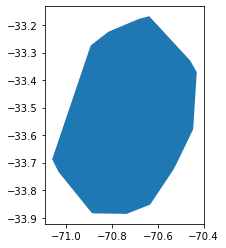

In [4]:
bnd.plot()

Extracting network from OSM database using OSMnx

In [5]:
# Create graph using OSMnx, extracting all available road networks
###
# method: osmnx.graph_from_polygon(.shp, network_type, etc.)
# ‘drive’         – get drivable public streets (but not service roads)
# ‘drive_service’ – get drivable public streets, including service roads
# ‘walk’          – get all streets and paths that pedestrians can use (this network type ignores one-way directionality)
# ‘bike’         – get all streets and paths that cyclists can use
# ‘all’          – download all (non-private) OSM streets and paths
# ‘all_private’  – download all OSM streets and paths, including private-access ones
###
G = ox.graph_from_polygon(bnd.geometry[0], network_type='all_private')

In [6]:
# Save graph file as .pk
with open('../../Air_pollution/02_data/santiago_osmnx_all_private_graph.pk', 'wb') as handle:
    pickle.dump(G, handle, protocol=2)

In [8]:
# Save as shapefile
G_shp_out_dir = '../../Air_pollution/02_data/'
ox.io.save_graph_shapefile(G, filepath=G_shp_out_dir)

# OD Trip simulation

Run the cell below to load the graph file

In [24]:
G =  pickle.load(open('../../Air_pollution/02_data/santiago_osmnx_all_private_graph.pk', 'rb'))

## Find closest road access points for centriods

In [3]:
# Read in the centroids (points) of Santiago blocks as geopandas dataframe
santiago_centriods_pts_path = "../../Air_pollution/02_data/santiago_block_centroids_wgs84.shp"
santiago_centriods_pts = gpd.read_file(santiago_centriods_pts_path)
santiago_centriods_pts.head(3)

,fid_1,CUT,REGION,PROVINCIA,COMUNA,NOMBRE_DIS,CODIGO_DIS,MANZENT,ZONA_CENSA,MANZANA,TOTAL_PERS,TOTAL_HOMB,TOTAL_MUJE,PERSONAS_0,PERSONAS_6,PERSONAS_1,PERSONAS_M,PERSONAS_E,PUEBLOS_IN,TOTAL_VIV_,TOTAL_VIV1,VIV_OCUPA_,TOTAL_VIVI,CANTIDAD_H,VIV_TIPO_C,VIV_TIPO_D,VIV_TIPO_T,VIV_TIPO_P,VIV_TIPO_M,VIV_TIPO_1,VIV_TIPO_O,VIV_PARED_,VIV_PARED1,VIV_PARE_1,VIV_PARE_2,VIV_PARE_3,VIV_PARE_4,VIV_TECHO_,VIV_TECHO1,VIV_TECH_1,VIV_TECH_2,VIV_TECH_3,VIV_TECH_4,VIV_TECH_5,VIV_PISO_P,VIV_PISO_R,VIV_PISO_B,VIV_PISO_C,VIV_PISO_T,VIV_MATERI,VIV_MATE_1,VIV_MATE_2,VIV_AGUA_R,VIV_AGUA_P,VIV_AGUA_C,VIV_AGUA_1,Manzana_ce,Manzana__1,Manzana__2,Manzana__3,centroid_x,centroid_y,geometry
0,1.0,13101.0,REGIÓN METROPOLITANA DE SANTIAGO,SANTIAGO,SANTIAGO,MATADERO,21.0,13101211002011,2.0,11.0,189.0,90,99,9,14,142,24,15,14,100.0,0.0,83.0,100.0,83.0,4.0,89.0,0.0,7.0,0.0,0.0,0.0,74.0,9.0,0.0,0.0,0.0,0.0,34.0,38.0,11.0,0.0,0.0,0.0,0.0,83.0,0.0,0.0,0.0,0.0,83.0,0.0,0.0,82.0,0.0,0.0,0.0,0.121693,0.126984,0.079365,0.074074,-7864610.0,-3958370.0,POINT (-70.64899 -33.47385)
1,2.0,13102.0,REGIÓN METROPOLITANA DE SANTIAGO,SANTIAGO,CERRILLOS,DIVINO MAESTRO,3.0,13102031005035,5.0,35.0,80.0,39,41,8,7,51,14,Indeterminado,5,20.0,0.0,20.0,20.0,23.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,12.0,4.0,2.0,0.0,0.0,5.0,0.0,14.0,1.0,0.0,0.0,0.0,14.0,0.0,6.0,0.0,0.0,12.0,8.0,0.0,20.0,0.0,0.0,0.0,0.187500,0.175000,999.000000,0.062500,-7874070.0,-3961680.0,POINT (-70.73397 -33.49865)
2,3.0,13102.0,REGIÓN METROPOLITANA DE SANTIAGO,SANTIAGO,CERRILLOS,DIVINO MAESTRO,3.0,13102031003007,3.0,7.0,29.0,13,16,Indeterminado,Indeterminado,17,8,0,Indeterminado,9.0,0.0,9.0,9.0,11.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,9.0,0.0,0.0,0.0,0.000000,0.275862,0.000000,999.000000,-7872570.0,-3961700.0,POINT (-70.72050 -33.49880)


In [4]:
# Collect useful columns: 'TOTAL_PERS', 'geometry'
santiago_centriods_pts_df = santiago_centriods_pts[['TOTAL_PERS', 'geometry']]

# Get latitude and longitude values for centroids
santiago_centriods_pts_df['centroid_lat'] = santiago_centriods_pts_df['geometry'].y
santiago_centriods_pts_df['centroid_lon'] = santiago_centriods_pts_df['geometry'].x

# Apply minmax scaler to the population column to create a sampling probability field
scaler = MinMaxScaler()
santiago_centriods_pts_df[['sample_prob_pop']] = scaler.fit_transform(santiago_centriods_pts_df[['TOTAL_PERS']])

# Add new index for all centroids
santiago_centriods_pts_df['id'] = santiago_centriods_pts_df.index
# Shift column 'id' to first position
first_column = santiago_centriods_pts_df.pop('id')
# Insert column using insert(position, column_name, first_column) function
santiago_centriods_pts_df.insert(0, 'id', first_column)

In [116]:
# Save santiago_centriods_pts_df
santiago_centriods_pts_df.to_csv('../02_data/santiago_centriods_pts_df.csv')

Find neartest access node and calculate the distance between the block centroid and the access node

In [45]:
# Find closest access points in the graph/network
# and the distance (meters) between the centroids and access points
# TAKES LONG TIME TO RUN!
id_accessOSMid_distancem = []
for row in tqdm(range(santiago_centriods_pts_df.shape[0])):
    row_id = row
    # Get the lat and lon of block centroids
    centroid_lat = santiago_centriods_pts_df.loc[santiago_centriods_pts_df['id']==row_id]['centroid_lat'][row_id]
    centroid_lon = santiago_centriods_pts_df.loc[santiago_centriods_pts_df['id']==row_id]['centroid_lon'][row_id]
    
    # find nearest access point
    access_OSMid, distance_m = ox.distance.nearest_nodes(G, centroid_lon, centroid_lat, return_dist=True)
    
    # Store the node id, OSM id of access point, and distance between access node and block centroid (unit: meters)
    id_accessOSMid_distancem.append([row_id, access_OSMid, distance_m])

100%|████████████████████████████████████| 47402/47402 [29:42:28<00:00,  2.26s/it]


In [51]:
# Create new dataframe for node id, OSM id of access point, and distance between access node and block centroid (unit: meters)
id_accessOSMid_distancem_df = pd.DataFrame(id_accessOSMid_distancem)

# Rename columns
id_accessOSMid_distancem_df = id_accessOSMid_distancem_df.rename(columns={0: 'id', 
                                            1: 'OSM_id',
                                            2: 'distance_m'})
# Save as csv
id_accessOSMid_distancem_df.to_csv('../02_data/id_accessOSMid_distance_m_df.csv')

Let's check the resulting dataframe

In [52]:
id_accessOSMid_distancem_df.head()

,id,OSM_id,distance_m
0,0,9000087782,13.310517
1,1,9192187479,40.396543
2,2,1856490959,29.102015
3,3,9000087770,8.491737
4,4,1846000011,26.467173


## Simulate trips between sampled OD pairs

### Prep the graph

In [3]:
# Load graph
G =  pickle.load(open('../../Air_pollution/02_data/santiago_osmnx_all_private_graph.pk', 'rb'))    

In [4]:
# Check graph attributes
# Number of nodes and edges
print('Graph has', G.number_of_nodes(), 'nodes')
print('Graph has', G.number_of_edges(), 'edges')

# Node attributes
for node_id, node_data in G.nodes.data():
    print('Node attriutes:', list(node_data.keys()))
    break

# Edge attributes
for from_node_id, to_node_id, edge_data in G.edges.data():
    print('Edge attributes', list(edge_data.keys()))
    break

Graph has 250809 nodes
Graph has 653862 edges
Node attriutes: ['y', 'x', 'osmid']
Edge attributes ['osmid', 'oneway', 'lanes', 'ref', 'name', 'highway', 'maxspeed', 'length']


### Add travel speed and travel time on edges

In [5]:
# Add travel speed
G_speed = ox.speed.add_edge_speeds(G)

# Add travel time, then
G_speed_time = ox.speed.add_edge_travel_times(G_speed)

Let's take a look at one of the edges

In [6]:
# Check edge attributes
# Units for key attributes
# "maxspeed"   : kilometers per hour
# "length"     : meters
# "speed_kph"  : kilometers per hour
# "travel_time": seconds
for from_node_id, to_node_id, edge_data in G_speed_time.edges.data():
    print('Edge attributes', edge_data)
    break

Edge attributes {'osmid': 272430239, 'oneway': True, 'lanes': '3', 'ref': '76', 'name': 'Camino a Melipilla', 'highway': 'primary', 'maxspeed': '60', 'length': 28.557, 'speed_kph': 60.0, 'travel_time': 1.7}


### Prepare sampling dataframe

In [7]:
# Read access point dataframe
# Columns: id, access point OSM id, distance between access point and block centroid
id_accessOSMid_distancem_df = pd.read_csv('../02_data/id_accessOSMid_distance_m_df.csv', index_col=0)

# Read block centroids and sampling probability dataframe
# Columns: id, total population, geometry, centroid lat, centroid lon, sample probability (based on population)
santiago_centroids_pts_df = pd.read_csv('../02_data/santiago_centriods_pts_df.csv', index_col=0)

# Join block centroid sampling dataframe and access point dataframe
santiago_centroid_access_pt_sampling_df = pd.merge(santiago_centroids_pts_df, id_accessOSMid_distancem_df,
                                          left_on='id', right_on='id')
# Save as csv
santiago_centroid_access_pt_sampling_df.to_csv('../02_data/santiago_centroid_access_pt_sampling_df.csv')
santiago_centroid_access_pt_sampling_df.head()

,id,TOTAL_PERS,geometry,centroid_lat,centroid_lon,sample_prob_pop,OSM_id,distance_m
0,0,189.0,POINT (-70.64899366639229 -33.4738510993451),-33.473851,-70.648994,0.020550,9000087782,13.310517
1,1,80.0,POINT (-70.73397429227 -33.49864999432129),-33.498650,-70.733974,0.008698,9192187479,40.396543
2,2,29.0,POINT (-70.7204995630082 -33.49879981500392),-33.498800,-70.720500,0.003153,1856490959,29.102015
3,3,146.0,POINT (-70.64971231861959 -33.4738510993451),-33.473851,-70.649712,0.015875,9000087770,8.491737
4,4,74.0,POINT (-70.71582832353079 -33.499099455591306),-33.499099,-70.715828,0.008046,1846000011,26.467173


### Run

In [8]:
try:
    # Load sampling dataframe
    santiago_centroid_access_pt_sampling_df = pd.read_csv('../02_data/santiago_centroid_access_pt_sampling_df.csv',
                                                          index_col=0)
    # Make a copy of the sampling dataframe, give it a short name because you will use it a lot afterwards
    sample_df = santiago_centroid_access_pt_sampling_df
    
    pt_id_lst = list(santiago_centroid_access_pt_sampling_df['id'])
    
    pt_prob_lst = list(santiago_centroid_access_pt_sampling_df['sample_prob_pop'])
    
    OD_df = pd.DataFrame(columns=['index',
                                  'sample_centroid_O_id',
                                  'sample_centroid_D_id',
                                  'sample_centroid_O_lat',
                                  'sample_centroid_O_lon',
                                  'sample_centroid_D_lat',
                                  'sample_centroid_D_lon',
                                  'O_access_pt_OSMid',
                                  'D_access_pt_OSMid',
                                  'O_distance_gap',
                                  'D_distance_gap',
                                  'OD_route',
                                  'OD_route_length_m',
                                  'OD_route_time_s'])
    index = 0
    epsilon = float('inf')
    simulation_count = 0
    simulation_threshold = 10000
    travel_time_lst = []
    
    pbar = tqdm(desc='while loop', total =simulation_threshold)
    
    while epsilon > 0.01 or simulation_count <= simulation_threshold:

        #Sample a point based on probability
        sample_O_pt = random.choices(pt_id_lst, pt_prob_lst)[0]
        sample_D_pt = random.choices(pt_id_lst, pt_prob_lst)[0]
        
        # Origin cannot be the same as destination point
        while sample_O_pt == sample_D_pt:
            sample_D_pt = random.choices(pt_id_lst, pt_prob_lst)[0]

        # O
        sample_O_lat = sample_df.loc[sample_df['id'] == sample_O_pt, 'centroid_lat'].iloc[0]
        sample_O_lon = sample_df.loc[sample_df['id'] == sample_O_pt, 'centroid_lon'].iloc[0]
        # D
        sample_D_lat = sample_df.loc[sample_df['id'] == sample_D_pt, 'centroid_lat'].iloc[0]
        sample_D_lon = sample_df.loc[sample_df['id'] == sample_D_pt, 'centroid_lon'].iloc[0]
        
        # OSM id of access point
        O_access_pt_OSMid = sample_df.loc[sample_df['id'] == sample_O_pt, 'OSM_id'].iloc[0]
        D_access_pt_OSMid = sample_df.loc[sample_df['id'] == sample_D_pt, 'OSM_id'].iloc[0]
        
        # Gap distance
        O_distance_gap = sample_df.loc[sample_df['id'] == sample_O_pt, 'distance_m'].iloc[0]
        D_distance_gap = sample_df.loc[sample_df['id'] == sample_D_pt, 'distance_m'].iloc[0]

        # Routing, minimizing travel time
        try:
            OD_route = nx.shortest_path(G_speed_time, O_access_pt_OSMid, D_access_pt_OSMid, weight='travel_time')
        except:
            continue

        OD_route_length = sum(ox.utils_graph.get_route_edge_attributes(G_speed_time, OD_route, 'length')) # meters
        OD_route_time =sum(ox.utils_graph.get_route_edge_attributes(G_speed_time, OD_route, 'travel_time')) # seconds

        # Append simulation results to dataframe
        OD_df = OD_df.append({'index' : index,
                              'sample_centroid_O_id' : sample_O_pt,
                              'sample_centroid_D_id' : sample_D_pt,
                              'sample_centroid_O_lat': sample_O_lat,
                              'sample_centroid_O_lon': sample_O_lon,
                              'sample_centroid_D_lat': sample_D_lat,
                              'sample_centroid_D_lon': sample_D_lon,
                              'O_access_pt_OSMid'    : O_access_pt_OSMid,
                              'D_access_pt_OSMid'    : O_access_pt_OSMid,
                              'O_distance_gap'       : O_distance_gap,
                              'D_distance_gap'       : D_distance_gap,
                              'OD_route'             : OD_route,
                              'OD_route_length_m'    : OD_route_length,
                              'OD_route_time_s'      : OD_route_time
                             },
        ignore_index = True)

        travel_time_lst.append(OD_route_time)

        if len(travel_time_lst) == 1:
            epsilon = float('inf')
        else:
            epsilon = abs(np.mean(travel_time_lst) - np.mean(travel_time_lst[:-1]))

        index += 1
        simulation_count += 1
        
        pbar.update(simulation_count)
    
except:
    print(simulation_count)

while loop: 50025003it [1:47:35, 14087.31it/s]                                  

In [9]:
OD_df.to_csv('../02_data/OD_df.csv')

Check the resulting dataframe

In [12]:
OD_df.head(3)

,index,sample_centroid_O_id,sample_centroid_D_id,sample_centroid_O_lat,sample_centroid_O_lon,sample_centroid_D_lat,sample_centroid_D_lon,O_access_pt_OSMid,D_access_pt_OSMid,O_distance_gap,D_distance_gap,OD_route,OD_route_length_m,OD_route_time_s
0,0,33419,4038,-33.387112,-70.555210,-33.460287,-70.702623,10575639764,10575639764,73.667341,37.587949,"[10575639764, 267181992, 267181971, 267181923,...",18458.726,1113.6
1,1,33162,9097,-33.373309,-70.574254,-33.544258,-70.608300,264179205,264179205,102.230397,76.199720,"[264179205, 264179000, 264179033, 264179045, 2...",21569.279,1187.3
2,2,29320,24068,-33.364232,-70.738286,-33.451144,-70.608480,2845956108,2845956108,16.145202,38.214329,"[2845956108, 2845956107, 1744679070, 267449268...",20224.922,997.6


# Travel frequency on road segments

In [59]:
# Read in OD simulation dataframe
OD_df = pd.read_csv('../02_data/OD_df.csv', index_col=0)

### Summarize node frequency
# Create new column that transform the OD route in txt format to list
OD_df['OD_route_lst'] = OD_df.apply(lambda row: [int(s) for s in row['OD_route'][1:-1].split(', ') if s.isdigit()],
                                       axis=1)

# List of all nodes in the travel paths
nodes_all_lst = list(OD_df['OD_route_lst'].explode())

# Dictionary of node and node frequencies
nodes_freq_dict = dict(Counter(nodes_all_lst))

### Add node frequency to the graph


In [61]:
dict(Counter(nodes_all_lst))

{10575639764: 1,
 267181992: 2,
 267181971: 2,
 267181923: 2,
 10575639749: 1,
 253436955: 1,
 10575639753: 1,
 253435762: 1,
 253436965: 1,
 253435778: 1,
 253436953: 1,
 253437045: 30,
 5324935590: 34,
 254245983: 23,
 934390811: 23,
 934390782: 108,
 934390788: 107,
 934392470: 128,
 349176262: 128,
 671806528: 137,
 4441169826: 137,
 131590946: 66,
 5562772406: 120,
 5451105277: 120,
 4243477244: 120,
 4553024509: 129,
 489110528: 245,
 5368536656: 265,
 405896792: 253,
 254240603: 250,
 3797540582: 250,
 4393865757: 55,
 3797540581: 57,
 4619877742: 57,
 285738771: 58,
 386184: 68,
 5933053032: 58,
 4986979528: 99,
 9202600583: 67,
 4986979531: 67,
 9202600553: 67,
 1691362559: 79,
 285738885: 86,
 370206271: 66,
 3191979659: 66,
 6358908269: 64,
 4449477391: 77,
 386272: 77,
 386261: 76,
 6708244369: 54,
 4456568203: 54,
 4456592061: 54,
 3370504678: 54,
 83325520: 54,
 102397642: 53,
 5873610985: 53,
 5272846298: 91,
 4456592065: 91,
 5659654341: 39,
 102381378: 65,
 102381375: 